In [1]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc

In [2]:
# Conexión a base de datos
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_STAGE',
                      UID = 'ussifods',
                      PWD = 'sifods')

In [3]:
query1 = """SELECT  * FROM [st].[MD_sistema_mooc_escuestas]"""
df = pd.read_sql_query(query1,conn)

In [7]:
df.head()

,CURID,DES_CURSO,NOMBRE_ACTIVIDAD,TIPO_ACTIVIDAD,FEEDBACKID,USUARIO,NOMBRES,APELLIDOS,IDNUMBER,NUM_RESPUESTA,FECHA_REALIZADA,NOMBRE_PREGUNTA,ORDEN_PREGUNTA,TIPO_PREGUNTA,OPCIONES,OPCION_ELEGIDA,RESPUESTA,FECHAREPORTE
0,11,Aprendizaje basado en proyectos: Aprender de m...,Encuesta de satisfacción,feedback,10,09763003,AMANDA,JAVIER NAJERA,9763003,3024,2022-07-15 21:46:40,Señale dos aspectos para mejorar el curso en l...,52,textarea,80|10,publicacion con anticipacion al curso\r\n,publicacion con anticipacion al curso\r\n,2022-09-26 23:56:09
1,11,Aprendizaje basado en proyectos: Aprender de m...,Encuesta de satisfacción,feedback,10,09763003,AMANDA,JAVIER NAJERA,9763003,3024,2022-07-15 21:46:40,Indique Ud. algún otro curso o cursos que requ...,53,textarea,80|10,manejo de las tabletas,manejo de las tabletas,2022-09-26 23:56:09
2,11,Aprendizaje basado en proyectos: Aprender de m...,Encuesta de satisfacción,feedback,10,09763003,AMANDA,JAVIER NAJERA,9763003,3024,2022-07-15 21:46:40,b) El desarrollo de la segunda unidad del curs...,35,multichoice,1\n|2\n|3\n|4,3,3\n,2022-09-26 23:56:09
3,11,Aprendizaje basado en proyectos: Aprender de m...,Encuesta de satisfacción,feedback,10,09763003,AMANDA,JAVIER NAJERA,9763003,3024,2022-07-15 21:46:40,c)\tEl desarrollo de la tercera unidad del cur...,36,multichoice,1\n|2\n|3\n|4,3,3\n,2022-09-26 23:56:09
4,24,Aprendizaje a nivel real Ciencia y Tecnología,Encuesta de satisfacción,feedback,55,21867265,BETTY BEATRIZ,SEBASTIAN FELIPA,21867265,3029,2022-07-15 21:58:01,label,1,label,"<p>\n <br></p>\n<h4 style=""font-size:1.7em;...",None,None,2022-09-26 23:56:09


In [44]:
#Numero de docentes por Cursos 
df1 = df.groupby('DES_CURSO')['IDNUMBER'].count()
df1 = pd.DataFrame(df1)
df1.reset_index(inplace=True)
df1.sort_values(by ='IDNUMBER', ascending=False,inplace=True)
df1.head()

,DES_CURSO,IDNUMBER
11,Aprendizaje basado en proyectos: Aprender de m...,48018
17,Educación Financiera,33231
67,Programa de metodologías STEAM - Secundaria,19855
58,Las competencias matemáticas en los primeros a...,16450
14,Conocimientos pedagógicos,10951


,level_0,index,DES_CURSO,IDNUMBER
0,0,0,Actuando frente a la Segunda Ola del COVID-19,102
1,1,1,Alfabetización Digital,2128
2,2,2,Aplicando estrategias basadas en el DUA,1144
3,3,3,Aplicando los principios DUA,1196
4,4,4,Aprendizaje a nivel real Ciencia y Tecnología,1628


In [23]:
df1.to_csv("D:/cursos.csv",sep=";",index=False)

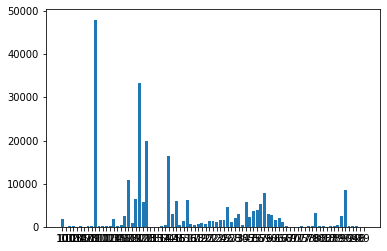

In [36]:
plt.bar(df1.CURID,df1.IDNUMBER)
plt.show()